<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [1]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-10-21 01:07:45--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-10-21 01:07:45 (95.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



First, download and load the test set:


In [2]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-10-21 01:07:53--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-10-21 01:07:54 (29.1 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [10]:
!conda install pydotplus

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.8-main

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |     pyhd3eb1b0_1          23 KB
    ------------------------------------------------------------
                                           Total:          23 KB

The following NEW packages will be INSTALLED:

  pydotplus          pkgs/main/noarch::pydotplus-2.0.2-pyhd3eb1b0_1



pydotplus-2.0.2      | 23 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [11]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def loanTest(mod_knn, mod_tree, mod_svm, mod_log):
        #Load Dataset
        df_test = pd.read_csv('loan_test.csv')
        #print(df_test.head(100))
        #print(df_test.shape)
        
        #Correct misspelling
        df_test.loc[df_test['education'] =='Bechalor', 'education'] = 'Bachelor'
        #print(df_test.head())
        
        #Convert to date-time object
        df_test['due_date'] = pd.to_datetime(df_test['due_date'])
        df_test['effective_date'] = pd.to_datetime(df_test['effective_date'])
        #print(df_test['due_date'].head(), df_test['effective_date'].head())
        
        #--Data visualization and pre-processing--
        #Initial peek
        stat_counts = df_test['loan_status'].value_counts()
        #print(stat_counts)
        #print(df_test['loan_status'].values)
        #print(df_test['terms'].values)
        #print(df_test.groupby(['terms'])['loan_status'].value_counts(normalize=True))
        ed_counts = df_test['education'].value_counts()
        df_test['dayofweek'] = df_test['effective_date'].dt.dayofweek
        #print(ed_counts)
        

        
        
        #--Preprocessing--
        #Binarization to weekend and weekday
        df_test['weekend'] = df_test['dayofweek'].apply(lambda x: 1 if(x>3) else 0)
        #print(df_test['weekend'].head())
        
        #Binarization of gender
        df_test['Gender'].replace(to_replace=['male', 'female'], value=[0, 1], inplace=True)
        #print(df_test['Gender'].head())
        

        
        #Binarization of loan status(y)
        #df_test['loan_status'].replace(to_replace=['PAIDOFF', 'COLLECTION'], value=[1, 0], inplace=True)
        #print(df_test['loan_status'].head())
        
        #Building featureset
        Feature = df_test[['Principal', 'terms', 'age', 'Gender', 'weekend']]
        Feature = pd.concat([Feature, pd.get_dummies(df_test['education'])], axis=1)
        Feature.drop(['Master or Above'], axis=1, inplace=True)
        #print(Feature.head(10))
        X = Feature
        #print(X[0:5])
        
        #Response variable
        y = df_test['loan_status'].values
        #print(y[0:5])
        
        #train/test split
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=119)
        #print("Train Set:")
        #print(X_train.shape, y_train.shape)
        #print("Test set:")
        #print(X_test.shape, y_test.shape)
        
        #Data Normalization
        X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
        X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
        #print("Transformed training features:")
        #print(X_train[0:5])
        #print("Transformed testing features:")
        #print(X_test[0:5])
        #print("Response:")
        #print(y_train[0:5])
        #encoding responses
        y_train_enc = pd.factorize(y_train)[0].tolist()
        y_test_enc = pd.factorize(y_test)[0].tolist()
        print("Encoded Response")
        print(y_train[0:50])
        print(y_train_enc[0:50])
        
        #---Evaluation tools---
        from sklearn.metrics import accuracy_score
        from sklearn.metrics import classification_report, confusion_matrix
        from sklearn.metrics import f1_score
        from sklearn.metrics import jaccard_score
        
        #---Predictions---
        yhat_knn = mod_knn.predict(X_test)
        yhat_tree = mod_tree.predict(X_test)
        yhat_svm = mod_svm.predict(X_test)
        yhat_log = mod_log.predict(X_test)
        
        acc_knn = accuracy_score(y_test_enc, yhat_knn)
        print("KNN Test Accuracy: ", acc_knn)
        
        acc_tree = accuracy_score(y_test_enc, yhat_tree)
        print("Decision Tree Test Accuracy: ", acc_tree)
        
        acc_svm = accuracy_score(y_test_enc, yhat_svm)
        print("SVM Test Accuracy: ", acc_svm)
        
        acc_log = accuracy_score(y_test_enc, yhat_log)
        print("Logistic Test Accuracy: ", acc_log)
        
        #---Evaluation Profiles: Test Set---
        #KNN
        rep_knn = classification_report(y_test_enc, yhat_knn) 
        print("KNN accuracy profile:")
        print(rep_knn)
        print()
        cnf_matrix_knn = confusion_matrix(y_test_enc, yhat_knn, labels=[0,1])
        f1_knn = f1_score(y_test_enc, yhat_knn, average='weighted')
        jac_knn = jaccard_score(y_test_enc, yhat_knn, pos_label=0)
        plt.figure()
        plot_confusion_matrix(cnf_matrix_knn, classes=['Paid-off(0)','Collection(1)'],normalize= False,  title='KNN Confusion matrix(Test Set)')
        
        #Decision Tree
        rep_tree = classification_report(y_test_enc, yhat_tree)
        print("Decision Tree accuracy profile:")
        print(rep_tree)
        print()
        cnf_matrix_tree = confusion_matrix(y_test_enc, yhat_tree, labels=[0,1])
        f1_tree = f1_score(y_test_enc, yhat_tree, average='weighted')
        jac_tree = jaccard_score(y_test_enc, yhat_tree, pos_label=0)
        plt.figure()
        plot_confusion_matrix(cnf_matrix_tree, classes=['Paid-off(0)','Collection(1)'],normalize= False,  title='Decision tree Confusion matrix(Test Set)')
        
        #SVM
        rep_svm = classification_report(y_test_enc, yhat_svm)
        print("SVM accuracy profile:")
        print(rep_svm)
        print()
        cnf_matrix_svm = confusion_matrix(y_test_enc, yhat_svm, labels=[0,1])
        f1_svm = f1_score(y_test_enc, yhat_svm, average='weighted')
        jac_svm = jaccard_score(y_test_enc, yhat_svm, pos_label=0)
        plt.figure()
        plot_confusion_matrix(cnf_matrix_svm, classes=['Paid-off(0)','Collection(1)'],normalize= False,  title='SVM Confusion matrix(Test Set)')
        
        #Logistic
        rep_log = classification_report(y_test_enc, yhat_log)
        print("Logistic Regression accuracy profile:")
        print(rep_log)
        cnf_matrix_log = confusion_matrix(y_test_enc, yhat_log, labels=[0,1])
        f1_log = f1_score(y_test_enc, yhat_log, average='weighted')
        jac_log = jaccard_score(y_test_enc, yhat_log, pos_label=0)
        plt.figure()
        plot_confusion_matrix(cnf_matrix_log, classes=['Paid-off(0)','Collection(1)'],normalize= False,  title='Logistic Confusion matrix(Test Set)')
        
        #---Comparison plot---
        xlabs = ['KNN', 'Dec-Tree', 'SVM', 'Logistic']
        accs = [acc_knn, acc_tree, acc_svm, acc_log]
        f1s = [f1_knn, f1_tree, f1_svm, f1_log]
        jacs = [jac_knn, jac_tree, jac_svm, jac_log]
        x_axis = np.arange(len(xlabs))
        plt.figure()
        
        width = 0.25
        plt.bar(x_axis, accs, width=width, label= 'Simple Accuracy')
        plt.bar(x_axis + width, f1s, width=width, label = 'F1-score')
        plt.bar(x_axis + (2*width), jacs, width=width, label = 'Jaccard-score')
        
        plt.xticks(x_axis, xlabs)
        plt.xlabel("Classifications")
        plt.ylabel("Score")
        plt.title("Classification accuracy comparison(Test Set)")
        plt.legend(loc=0)
        plt.show()

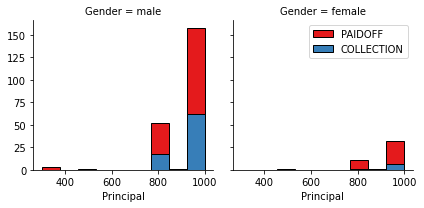

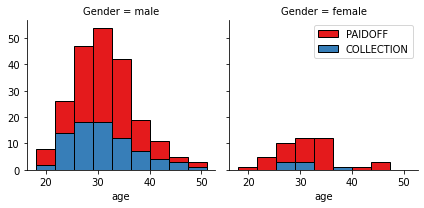

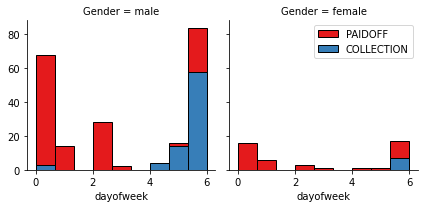

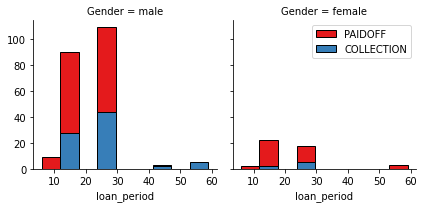

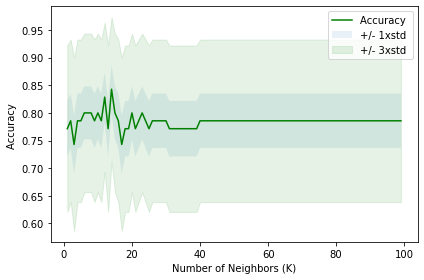

The best KNN accuracy was  84.28571428571429 % reached at k= 14
DecisionTrees's Accuracy:  0.7857142857142857
SVM Accuracy:  0.7571428571428571
Logistic Regression Accuracy:  0.8


KNN accuracy profile:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        55
           1       1.00      0.27      0.42        15

    accuracy                           0.84        70
   macro avg       0.92      0.63      0.67        70
weighted avg       0.87      0.84      0.80        70


Confusion matrix, without normalization
[[55  0]
 [11  4]]
Decision Tree accuracy profile:
              precision    recall  f1-score   support

           0       0.80      0.96      0.88        55
           1       0.50      0.13      0.21        15

    accuracy                           0.79        70
   macro avg       0.65      0.55      0.54        70
weighted avg       0.74      0.79      0.73        70


Confusion matrix, without normalization
[[53  2]
 

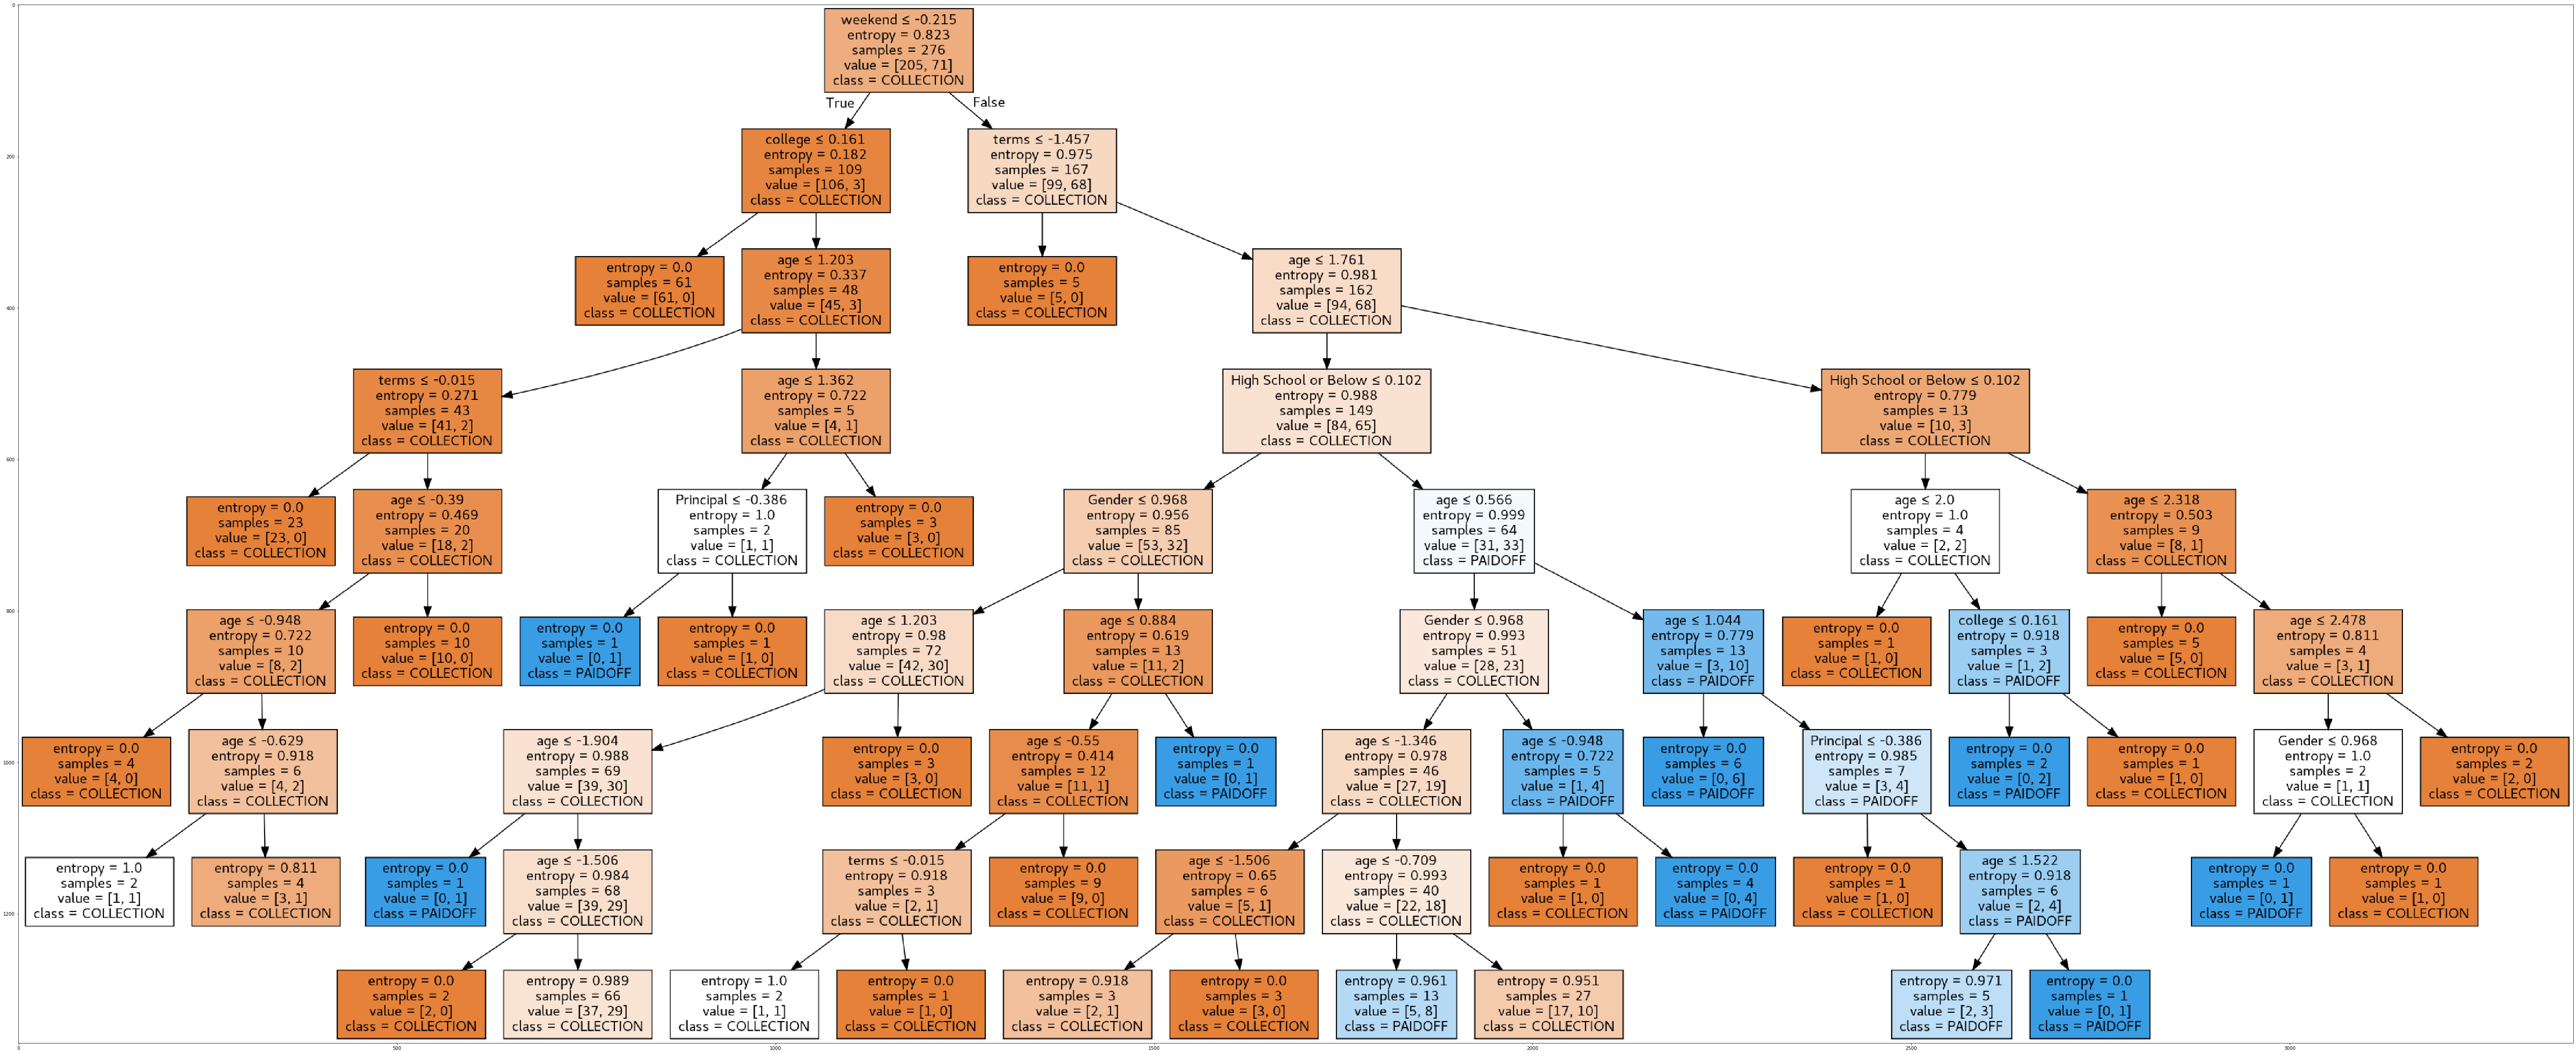

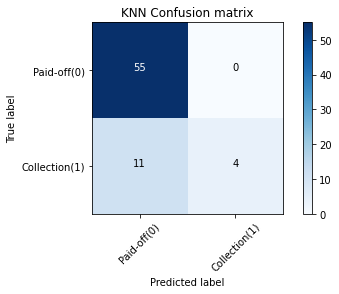

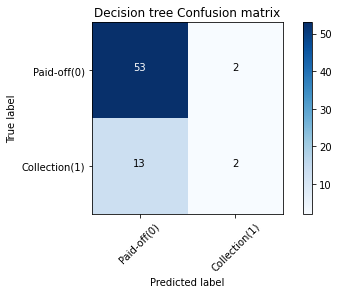

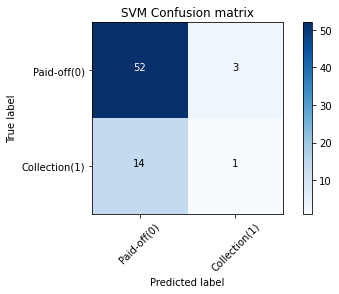

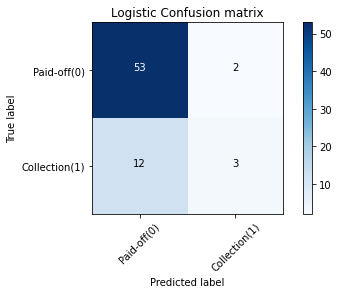

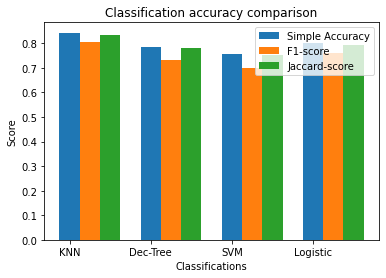

Encoded Response
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
[0, 0, 1, 0, 0]
KNN Test Accuracy:  0.7142857142857143
Decision Tree Test Accuracy:  0.7346938775510204
SVM Test Accuracy:  0.7346938775510204
Logistic Test Accuracy:  0.7959183673469388
KNN accuracy profile:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        36
           1       0.33      0.08      0.12        13

    accuracy                           0.71        49
   macro avg       0.54      0.51      0.48        49
weighted avg       0.63      0.71      0.64        49


Confusion matrix, without normalization
[[34  2]
 [12  1]]
Decision Tree accuracy profile:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83        36
           1       0.50      0.31      0.38        13

    accuracy                           0.73        49
   macro avg       0.64      0.60      0.61        49
weighted avg       0.71     

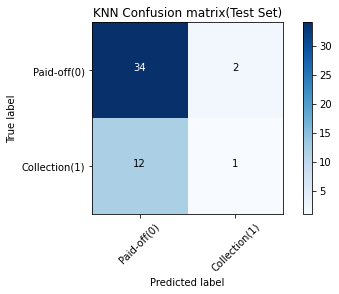

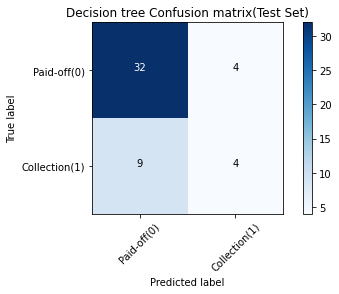

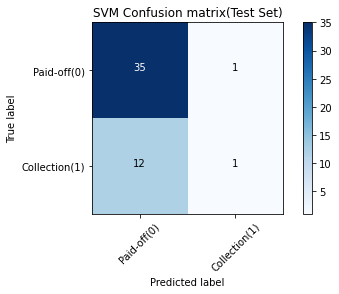

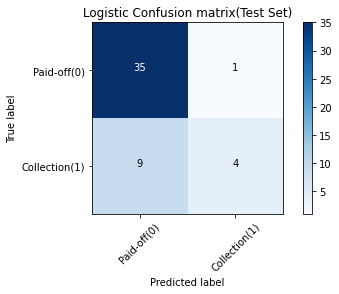

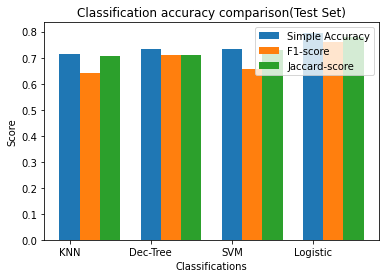

In [13]:
def loanApp():
    #Load Dataset
    df = pd.read_csv('loan_train.csv')
    #print(df.head(100))
    #print(df.shape)
    
    #Correct misspelling
    df.loc[df['education'] =='Bechalor', 'education'] = 'Bachelor'
    #print(df.head())
    
    #Convert to date-time object
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    #print(df['due_date'].head(), df['effective_date'].head())
    
    #--Data visualization and pre-processing--
    #Initial peek
    stat_counts = df['loan_status'].value_counts()
    #print(stat_counts)
    #print(df['loan_status'].values)
    #print(df['terms'].values)
    #print(df.groupby(['terms'])['loan_status'].value_counts(normalize=True))
    ed_counts = df['education'].value_counts()
    #print(ed_counts)
    
    #plotting
    import seaborn as sns
    #plotting loan-status vs Principal
    bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
    g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
    g.map(plt.hist, 'Principal', bins=bins, ec="k")
    g.axes[-1].legend()
    plt.show()
    
    #plotting loan status vs age
    bins = np.linspace(df.age.min(), df.age.max(), 10)
    g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
    g.map(plt.hist, 'age', bins=bins, ec="k")
    g.axes[-1].legend()
    plt.show()
    
    #plotting loan status vs day of loan provision
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
    g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
    g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
    g.axes[-1].legend()
    plt.show()
    
    #Plotting loan status vs loaning period
    df['loan_period'] = df['due_date'] - df['effective_date']
    df['loan_period'] = df['loan_period'].dt.days
    bins = np.linspace(df.loan_period.min(), df.loan_period.max(), 10)
    g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
    g.map(plt.hist, 'loan_period', bins=bins, ec= "k")
    g.axes[-1].legend()
    plt.show()
    
    
    #--Preprocessing--
    #Binarization to weekend and weekday
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if(x>3) else 0)
    #print(df['weekend'].head())
    
    #Binarization of gender
    df['Gender'].replace(to_replace=['male', 'female'], value=[0, 1], inplace=True)
    #print(df['Gender'].head())
    
 
    
    #Binarization of loan status(y)
    #df['loan_status'].replace(to_replace=['PAIDOFF', 'COLLECTION'], value=[1, 0], inplace=True)
    #print(df['loan_status'].head())
    
    #Building featureset
    Feature = df[['Principal', 'terms', 'age', 'Gender', 'weekend']]
    Feature = pd.concat([Feature, pd.get_dummies(df['education'])], axis=1)
    Feature.drop(['Master or Above'], axis=1, inplace=True)
    #print(Feature.head(10))
    X = Feature
    #print(X[0:5])
    
    #Response variable
    y = df['loan_status'].values
    #print(y[0:5])
    
    #train/test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=79)
    #print("Train Set:")
    #print(X_train.shape, y_train.shape)
    #print("Test set:")
    #print(X_test.shape, y_test.shape)
    
    #Data Normalization
    X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
    #print("Transformed training features:")
    #print(X_train[0:5])
    #print("Transformed testing features:")
    #print(X_test[0:5])
    #print("Response:")
    #print(y_train[0:5])
    #encoding responses
    y_train_enc = pd.factorize(y_train)[0].tolist()
    y_test_enc = pd.factorize(y_test)[0].tolist()
    #print("Encoded Response")
    #print(y_train[0:50])
    #print(y_train_enc[0:50])
    
    #Evaluation tools
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import f1_score
    from sklearn.metrics import jaccard_score
    
    #---Classification---
    #KNN: model
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import metrics
    nbrs =100 #Neighbourhood range
    
    #KNN:Prediction and testing
    #optimizing k
    mean_acc = np.zeros((nbrs-1))
    std_acc = np.zeros((nbrs-1))
    
    for n in range(1, nbrs):
        neighs = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train_enc)
        yhat_knn = neighs.predict(X_test)
        mean_acc[n-1]= metrics.accuracy_score(y_test_enc, yhat_knn)
        std_acc[n-1] = np.std(yhat_knn==y_test_enc)/np.sqrt(yhat_knn.shape[0])
        
    #Plot the optimization
    plt.plot(range(1, nbrs), mean_acc, 'g')
    plt.fill_between(range(1, nbrs), mean_acc-1*std_acc, mean_acc+1*std_acc, alpha=0.10)
    plt.fill_between(range(1,nbrs),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
    plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Number of Neighbors (K)')
    plt.tight_layout()
    plt.show()
    acc_knn = mean_acc.max()
    print( "The best KNN accuracy was ", acc_knn*100,"%" " reached at k=", mean_acc.argmax()+1)
    
    #---
    
    #Decision tree:model
    from sklearn.tree import DecisionTreeClassifier
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth=8)
    fitTree = loanTree.fit(X_train, y_train_enc)
    
    #Decision tree:Prediction and testing
    yhat_tree = loanTree.predict(X_test)
    acc_tree = metrics.accuracy_score(y_test_enc, yhat_tree)
    print("DecisionTrees's Accuracy: ", acc_tree)
    
    #Decision tree:Visualization
    from io import StringIO
    import pydotplus
    import matplotlib.image as mpimg
    from sklearn import tree
    
    dot_data = StringIO()
    filename = "drugtree.png"
    featureNames = X.columns
    out = tree.export_graphviz(loanTree, feature_names=featureNames,out_file=dot_data, class_names=np.unique(y_train), filled=True, special_characters=True, rotate=False)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(filename)
    img = mpimg.imread(filename)
    plt.figure(figsize=(100, 200))
    plt.imshow(img,interpolation='nearest')
    #---
    
    #SVM:model
    from sklearn import svm
    clf = svm.SVC(kernel='rbf')
    clf.fit(X_train, y_train_enc)
    
    #SVM:Prediction and testing
    yhat_svm = clf.predict(X_test)
    acc_svm = metrics.accuracy_score(y_test_enc, yhat_svm)
    print("SVM Accuracy: ", acc_svm)
    #---
    #Logistic Regression:model
    from sklearn.linear_model import LogisticRegression
    LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train, y_train_enc)
    
    #Logistic Regression:Prediction and testing
    yhat_log = LR.predict(X_test)
    acc_log = metrics.accuracy_score(y_test_enc, yhat_log)
    print("Logistic Regression Accuracy: ", acc_log)
    print()
    print()
    #---
    
    #---Evaluation: Model Comparison Training Set---
    #KNN
    val_neigh = KNeighborsClassifier(n_neighbors=14).fit(X_train, y_train_enc)
    yhat_val_knn = val_neigh.predict(X_test)
    rep_knn = classification_report(y_test_enc, yhat_val_knn) 
    print("KNN accuracy profile:")
    print(rep_knn)
    print()
    cnf_matrix_knn = confusion_matrix(y_test_enc, yhat_val_knn, labels=[0,1])
    f1_knn = f1_score(y_test_enc, yhat_val_knn, average='weighted')
    jac_knn = jaccard_score(y_test_enc, yhat_val_knn, pos_label=0)
    plt.figure()
    plot_confusion_matrix(cnf_matrix_knn, classes=['Paid-off(0)','Collection(1)'],normalize= False,  title='KNN Confusion matrix')
    
    #Decision Tree
    rep_tree = classification_report(y_test_enc, yhat_tree)
    print("Decision Tree accuracy profile:")
    print(rep_tree)
    print()
    cnf_matrix_tree = confusion_matrix(y_test_enc, yhat_tree, labels=[0,1])
    f1_tree = f1_score(y_test_enc, yhat_tree, average='weighted')
    jac_tree = jaccard_score(y_test_enc, yhat_tree, pos_label=0)
    plt.figure()
    plot_confusion_matrix(cnf_matrix_tree, classes=['Paid-off(0)','Collection(1)'],normalize= False,  title='Decision tree Confusion matrix')
    
    #SVM
    rep_svm = classification_report(y_test_enc, yhat_svm)
    print("SVM accuracy profile:")
    print(rep_svm)
    print()
    cnf_matrix_svm = confusion_matrix(y_test_enc, yhat_svm, labels=[0,1])
    f1_svm = f1_score(y_test_enc, yhat_svm, average='weighted')
    jac_svm = jaccard_score(y_test_enc, yhat_svm, pos_label=0)
    plt.figure()
    plot_confusion_matrix(cnf_matrix_svm, classes=['Paid-off(0)','Collection(1)'],normalize= False,  title='SVM Confusion matrix')
    
    #Logistic
    rep_log = classification_report(y_test_enc, yhat_log)
    print("Logistic Regression accuracy profile:")
    print(rep_log)
    cnf_matrix_log = confusion_matrix(y_test_enc, yhat_log, labels=[0,1])
    f1_log = f1_score(y_test_enc, yhat_log, average='weighted')
    jac_log = jaccard_score(y_test_enc, yhat_log, pos_label=0)
    plt.figure()
    plot_confusion_matrix(cnf_matrix_log, classes=['Paid-off(0)','Collection(1)'],normalize= False,  title='Logistic Confusion matrix')
    
    #---Comparison plot---
    xlabs = ['KNN', 'Dec-Tree', 'SVM', 'Logistic']
    accs = [acc_knn, acc_tree, acc_svm, acc_log]
    f1s = [f1_knn, f1_tree, f1_svm, f1_log]
    jacs = [jac_knn, jac_tree, jac_svm, jac_log]
    x_axis = np.arange(len(xlabs))
    plt.figure()
    
    width = 0.25
    plt.bar(x_axis, accs, width=width, label= 'Simple Accuracy')
    plt.bar(x_axis + width, f1s, width=width, label = 'F1-score')
    plt.bar(x_axis + (2*width), jacs, width=width, label = 'Jaccard-score')
    
    plt.xticks(x_axis, xlabs)
    plt.xlabel("Classifications")
    plt.ylabel("Score")
    plt.title("Classification accuracy comparison")
    plt.legend(loc=0)
    plt.show()
    #-----------------------------------------------------------------------
    #Test Set Evaluation
    loanTest(mod_knn=val_neigh, mod_tree=loanTree, mod_svm=clf, mod_log=LR)

loanApp()

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
